In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Preprocessing

In [101]:
# Keep only needed columns
feature_names = [
    "Age", "Workclass", "Education", 
    "Occupation", "Relationship", "Race", 
    "Sex", "Capital Gain", "Capital Loss", 
    "Hours per week", "Country", "label"
]

df = pd.DataFrame(
  np.genfromtxt('dataset/adult.csv', delimiter=', ', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)

# Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()


# Declare categorical columns
categorical_columns=[
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country", "label"
]

# Assign type to features
for feature in feature_names:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

# Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35 , 90],labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
            x=df["Hours per week"],
            bins=[0.9, 25, 39, 40, 55, 100],
            labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"])

# Replace "Husband" and "Wife" values with the unisex "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

# Will have income >50k (1 or 0)
df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)

df.sample(5)

/tmp/ipykernel_2812678/1809994134.py:40: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Relationship"] = df["Relationship"].replace('Husband','Married')
/tmp/ipykernel_2812678/1809994134.py:41: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Relationship"] = df["Relationship"].replace('Wife','Married')
/tmp/ipykernel_2812678/1809994134.py:44: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, 

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
2212,Aged,Private,HS-grad,Handlers-cleaners,Married,White,Male,0,0,FullTime,United-States,0
24570,Young,Private,Bachelors,Exec-managerial,Not-in-family,White,Female,0,0,MidTime,United-States,0
30764,Young,Private,11th,Other-service,Married,Black,Female,0,0,MidTime,United-States,0
2807,Aged,Private,HS-grad,Other-service,Unmarried,Black,Female,0,0,MidTime,United-States,0
6553,Aged,Local-gov,Bachelors,Prof-specialty,Unmarried,White,Female,0,0,OverTime,United-States,0


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             30162 non-null  category
 1   Workclass       30162 non-null  category
 2   Education       30162 non-null  category
 3   Occupation      30162 non-null  category
 4   Relationship    30162 non-null  category
 5   Race            30162 non-null  category
 6   Sex             30162 non-null  category
 7   Capital Gain    30162 non-null  int64   
 8   Capital Loss    30162 non-null  int64   
 9   Hours per week  30162 non-null  category
 10  Country         30162 non-null  category
 11  label           30162 non-null  category
dtypes: category(10), int64(2)
memory usage: 1005.5 KB


## Getting Metrics

In [103]:
# Calculate some metrics - variance, mean square error, standard error

binary_values_age = df["Age"].apply(lambda x: 1 if x == "Aged" else 0).values

original_variance_age = np.var(binary_values_age)
original_standard_error_age = np.sqrt(original_variance_age / len(binary_values_age))

binary_values_sex = df["Sex"].apply(lambda x: 1 if x == "Male" else 0).values

original_variance_sex = np.var(binary_values_sex)
original_standard_error_sex = np.sqrt(original_variance_sex / len(binary_values_sex))

print(original_variance_age, original_standard_error_age)     
print(original_variance_sex, original_standard_error_sex) 

0.24801741528267307 0.0028675501424498223
0.21913490856907564 0.002695415464056256


## Model Creation

In [104]:
# Data preprocessing to train model
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tabular_data = Tabular(
   df,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# Split data into training and (validation + test) datasets
train, X_temp, train_labels, y_temp  = \
    train_test_split(x[:, :-1], x[:, -1], train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, val_labels, test_labels = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

test_labels = test_labels.astype(int)

print('Training data shape:   {}'.format(train.shape))
print('Validation data shape:  {}'.format(val.shape))
print('Test data shape:        {}'.format(test.shape))

# Train a Random Forest model
model = RandomForestClassifier(random_state=123)
model.fit(train, train_labels)

predict_function=lambda z: model.predict_proba(transformer.transform(z))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

display(tabular_data.target_column)
display(train_labels[:2])

Training data shape:   (21113, 99)
Validation data shape:  (4524, 99)
Test data shape:        (4525, 99)


'label'

array([1., 0.])

In [105]:
# Model Predictions
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model.predict(test)
test_df["prediction"] = predictions

test_df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label,prediction
3614,Aged,Self-emp-not-inc,Some-college,Craft-repair,Married,White,Male,0.0,0.0,MidTime,United-States,0,0.0
2815,Young,Private,Bachelors,Exec-managerial,Not-in-family,White,Male,0.0,0.0,OverTime,United-States,0,0.0
2920,Young,Local-gov,Some-college,Tech-support,Not-in-family,White,Male,14344.0,0.0,OverTime,United-States,1,1.0
4142,Aged,Private,HS-grad,Adm-clerical,Not-in-family,White,Female,0.0,0.0,FullTime,United-States,0,0.0
1048,Aged,Private,Assoc-voc,Exec-managerial,Married,White,Male,0.0,0.0,FullTime,United-States,0,0.0


Test: accuracy=0.8513
Test: TP=734, TN=3118, FP=263, FN=410


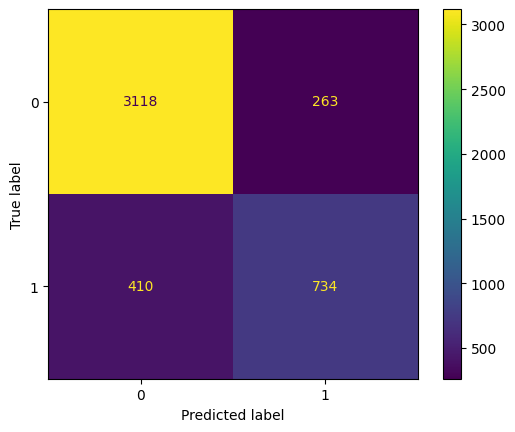

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(test_labels, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(test_labels, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

## Privacy

Defining some helper functions here,

In [107]:
import random
import math
from tabulate import tabulate
random.seed(123)  # Set the random seed for reproducibility

# randomized response 
def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

# apply privacy to an attribute
def privatize_attribute(column, true_label, false_label, p, q, variances, mses, sdes):
    # Convert labels to binary values
    binary_values = column.apply(lambda x: 1 if x == true_label else 0).values
    
    # Apply randomized response
    privatized_values = pd.Series([rand_resp(x, p, q) for x in binary_values], index=column.index)

    # Calculate some metrics - variance, mean square error, standard error
    estimated_proportion = np.mean(privatized_values)
    true_proportion = np.mean(binary_values)
    mse = (estimated_proportion - true_proportion) ** 2
    variance_individual = np.var(privatized_values)
    standard_error = np.sqrt(variance_individual / len(privatized_values))
    
    variances.append(variance_individual)
    mses.append(mse)
    sdes.append(standard_error)
    
    # Convert back to original labels
    return privatized_values.apply(lambda x: true_label if x == 1 else false_label)

# get the value of p and q for a certain epsilon
def get_p_q(epsilon):
    p = math.exp(epsilon)/(1+math.exp(epsilon))
    return p, p

We also define a function to train a classifier with privatized data. It also stores the accuracy for later use.

In [108]:
# Implement Private Classifier
def private_classifier(df, accuracies):
    tabular_data_private = Tabular(
    df,
    categorical_columns=[
    "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
    ],
    target_column='label'
    )
    transformer_private = TabularTransform().fit(tabular_data_private)
    class_names = transformer_private.class_names
    x_private = transformer_private.transform(tabular_data_private)

    # Split data into training and (validation + test) datasets
    train_private, X_private_temp, train_labels_private, y_private_temp  = \
        train_test_split(x_private[:, :-1], x_private[:, -1], train_size=0.70, random_state = 123)

    # Split data validation and test sets
    val_private, test_private, val_labels_private, test_labels_private = train_test_split(X_private_temp, y_private_temp, test_size=0.5, random_state=123)

    test_labels_private = test_labels_private.astype(int)

    # print('Private Classfier')
    # print('Training data shape:   {}'.format(train_private.shape))
    # print('Validation data shape:  {}'.format(val_private.shape))
    # print('Test data shape:        {}'.format(test_private.shape))

    # Train a Random Forest model
    model_private = RandomForestClassifier(random_state=123)
    model_private.fit(train_private, train_labels_private)

    predict_function_private=lambda z: model_private.predict_proba(transformer_private.transform(z))

    # # Convert the transformed data back to Tabular instances
    train_data_private = transformer_private.invert(train_private)
    test_data_private = transformer_private.invert(test_private)

    test_df_private = test_data_private.to_pd()
    test_df_private["label"] = test_labels_private
    predictions_private = model_private.predict(test_private)
    test_df_private["prediction"] = predictions_private

    accuracy_private = accuracy_score(test_labels_private, predictions_private)
    accuracies.append(accuracy_private)
    print(f'\nTest: {accuracy_private=:.4f}\n')


We compute the cross-tabulation on the original data to see how many people exist in value combinations of the two sensitive attributes.

In [109]:
# Showing cross tabulation
print("\nOriginal Cross-tabulation:")
original_crosstab = pd.crosstab(df['Age'], df['Sex'], margins=True, margins_name="Total")
print(tabulate(original_crosstab, headers='keys', tablefmt='pretty'))


Original Cross-tabulation:
+-------+--------+-------+-------+
|  Age  | Female | Male  | Total |
+-------+--------+-------+-------+
| Young |  4960  | 8778  | 13738 |
| Aged  |  4822  | 11602 | 16424 |
| Total |  9782  | 20380 | 30162 |
+-------+--------+-------+-------+


We then vary the epsilon to see how the added noise would affect the cross-tabulation. We also record the variance, mean square error, standard error and classifier accuracy for each epsilon. 

The cross-tabulation for the privatized values are shown, as well as the error in comparison with the original values.

In [110]:
# List of epsilon values
epsilon_values = [0.1, 0.2, 0.5, 1, 2, 5, 10]

variances_age = []
variances_sex = []

mse_age = []
mse_sex = []

sde_age = []
sde_sex = []

accuracies = []

privatized_crosstabs = {}

def get_error(original_crosstab, privatized_crosstab):
    print("\nError:")
    print(tabulate(original_crosstab - privatized_crosstab, headers='keys', tablefmt='pretty'))

# Loop through each epsilon value and print the results
for epsilon in epsilon_values:
    p, q = get_p_q(epsilon)
    print(f"Epsilon {epsilon} - p: {p}, q: {q}")

    # Create a copy of the original data
    df_private = df.copy(deep=True)

    # Apply randomized response to Age and Sex
    df_private['Age'] = privatize_attribute(df_private['Age'], 'Aged', 'Young', p, q, variances_age, mse_age, sde_age)
    df_private['Sex'] = privatize_attribute(df_private['Sex'], 'Male', 'Female', p, q, variances_sex, mse_sex, sde_sex)

    privatized_crosstab = pd.crosstab(df_private['Age'], df_private['Sex'], margins=True, margins_name="Total")
    privatized_crosstabs[epsilon] = privatized_crosstab
    print(tabulate(privatized_crosstab, headers='keys', tablefmt='pretty'))
    get_error(original_crosstab, privatized_crosstab)

    private_classifier(df_private, accuracies)



Epsilon 0.1 - p: 0.52497918747894, q: 0.52497918747894
+-------+--------+-------+-------+
|  Age  | Female | Male  | Total |
+-------+--------+-------+-------+
| Aged  |  7481  | 7688  | 15169 |
| Young |  7444  | 7549  | 14993 |
| Total | 14925  | 15237 | 30162 |
+-------+--------+-------+-------+

Error:
+-------+--------+------+-------+
|  Age  | Female | Male | Total |
+-------+--------+------+-------+
| Aged  | -2659  | 3914 | 1255  |
| Total | -5143  | 5143 |   0   |
| Young | -2484  | 1229 | -1255 |
+-------+--------+------+-------+

Test: accuracy_private=0.8469

Epsilon 0.2 - p: 0.549833997312478, q: 0.549833997312478
+-------+--------+-------+-------+
|  Age  | Female | Male  | Total |
+-------+--------+-------+-------+
| Aged  |  7256  | 7837  | 15093 |
| Young |  7269  | 7800  | 15069 |
| Total | 14525  | 15637 | 30162 |
+-------+--------+-------+-------+

Error:
+-------+--------+------+-------+
|  Age  | Female | Male | Total |
+-------+--------+------+-------+
| Aged  | 

Plotting the variances, mean square errors and standard errors as a function of epsilon.

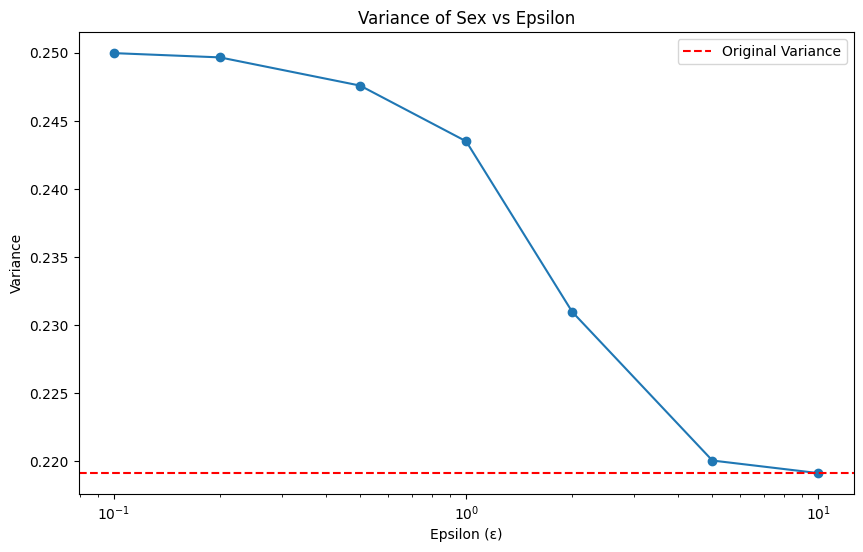

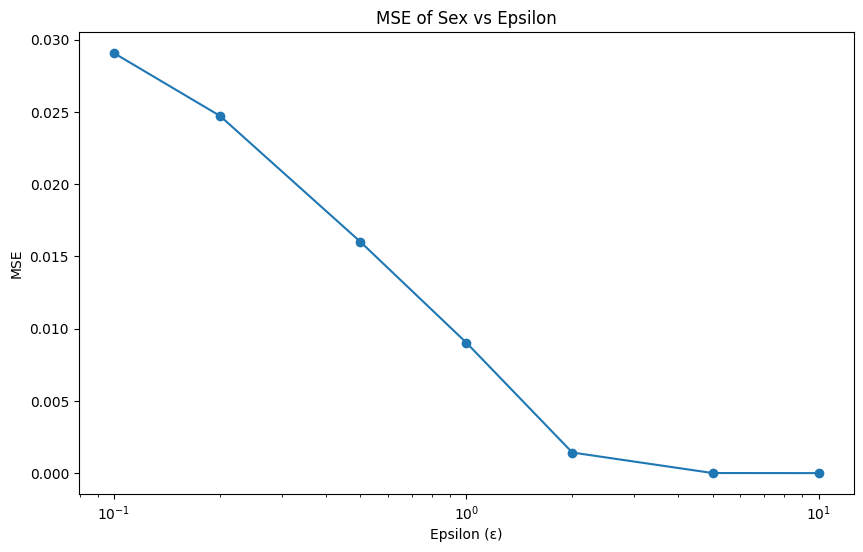

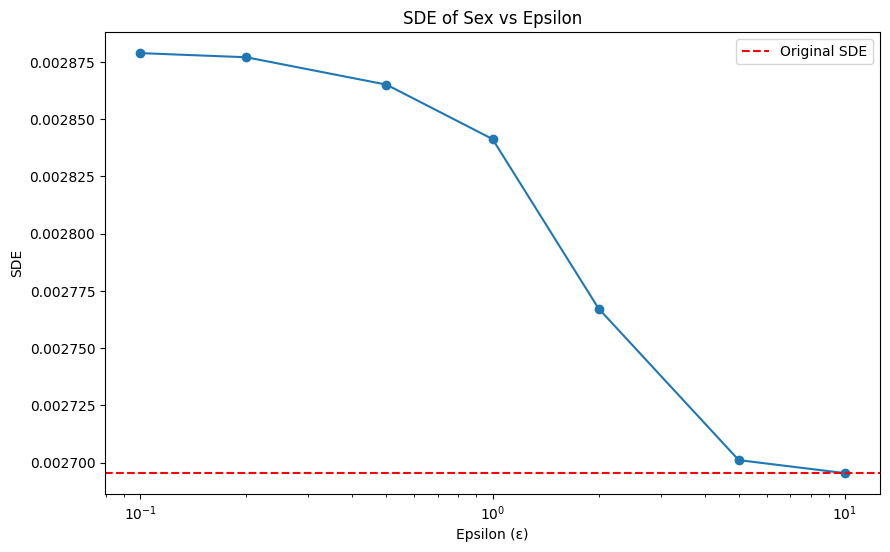

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, variances_sex, marker='o')
plt.title('Variance of Sex vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Variance')
plt.xscale('log')  
plt.axhline(y=original_variance_sex, color='r', linestyle='--', label='Original Variance')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, mse_sex, marker='o')
plt.title('MSE of Sex vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('MSE')
plt.xscale('log')  
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, sde_sex, marker='o')
plt.title('SDE of Sex vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('SDE')
plt.xscale('log')  
plt.axhline(y=original_standard_error_sex, color='r', linestyle='--', label='Original SDE')
plt.legend()
plt.show()

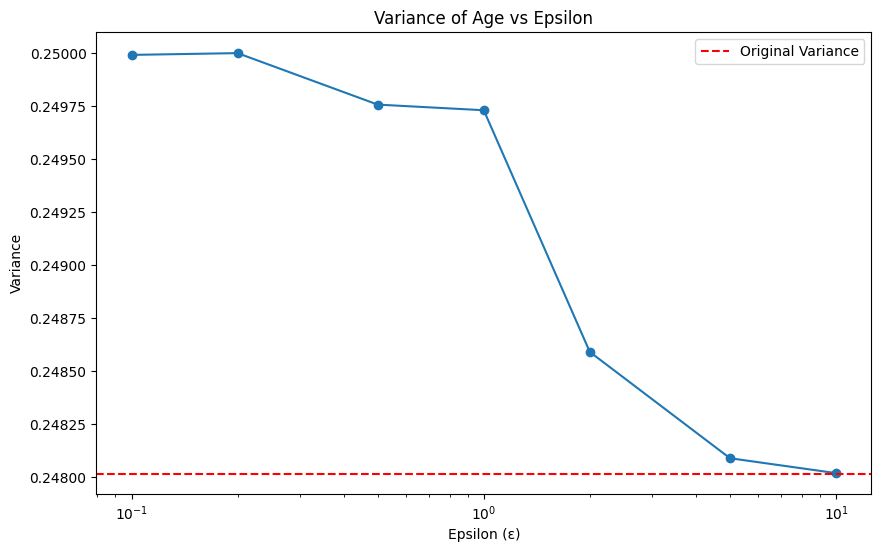

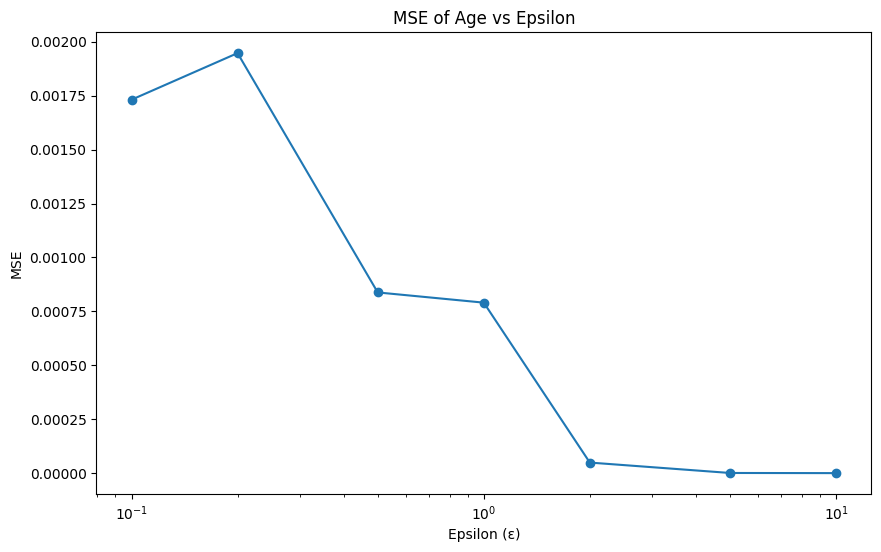

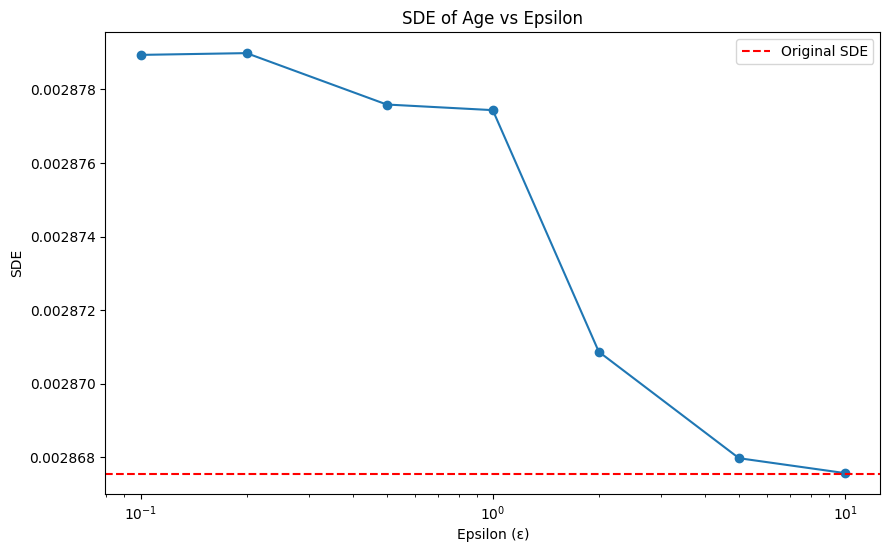

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, variances_age, marker='o')
plt.title('Variance of Age vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Variance')
plt.xscale('log')  
plt.axhline(y=original_variance_age, color='r', linestyle='--', label='Original Variance')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, mse_age, marker='o')
plt.title('MSE of Age vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('MSE')
plt.xscale('log')  
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, sde_age, marker='o')
plt.title('SDE of Age vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('SDE')
plt.xscale('log')  
plt.axhline(y=original_standard_error_age, color='r', linestyle='--', label='Original SDE')
plt.legend()
plt.show()

From the plots, the SDE, variance and MSE decrease as epsilon increases. This is expected because higher values of ε correspond to less noise and more accurate privatized results. However, increasing ε reduces privacy guarantees.

From the graphs:
    Around ϵ=1, there is a noticeable reduction in utility without excessively compromising privacy.
    Higher ε values (e.g., ϵ>1) lead to minimal further improvement in utility, which might not justify the loss of privacy.

To choose an appropriate epsilon, it highly depends on the use case. If high utility is critical, I would choose a ε > 2, which seems like a good trade-off between privacy and accuracy. If privacy is more important, then I would keep ε < 2.

In our case, we will be choosing what seems like a good balanced option of ε = 1. It provides slight utility improvements with reasonable privacy.

Now we compare the accuracy of the classifier trained on datasets with varying epsilon.

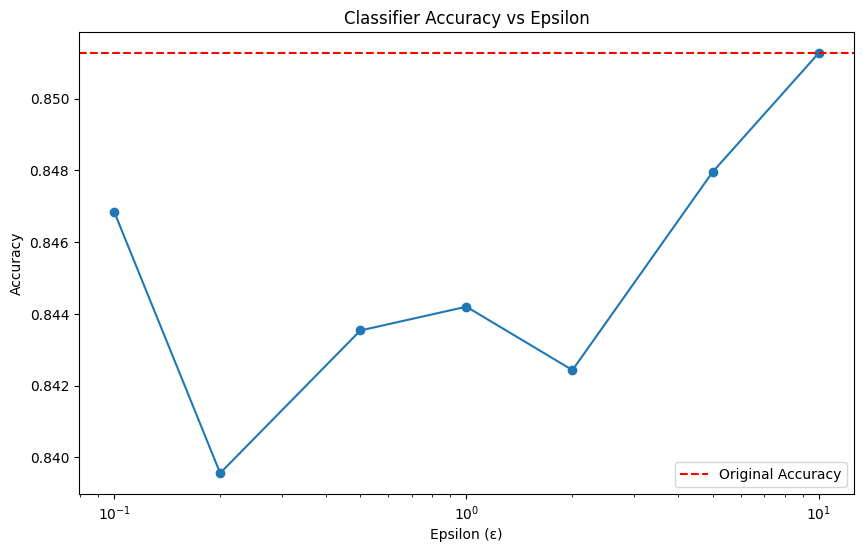

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o')
plt.title('Classifier Accuracy vs Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.xscale('log')  
plt.axhline(y=accuracy, color='r', linestyle='--', label='Original Accuracy')
plt.legend()
plt.show()

Comparing the accuracy for the classifier trained on different values of epsilon, there is no clear trend. However, it is noted that for any epsilon lower than 10, the accuracy is lower than the accuracy of the original classifier which is expected due to the added noise. For Epsilon 10, the accuracy is equal to the original, but this is also expected, since there is practically no difference between the original and privatized attributes at this epsilon.

## Estimation   

In [114]:
original_crosstab

Sex,Female,Male,Total
Age,,,
Young,4960,8778,13738
Aged,4822,11602,16424
Total,9782,20380,30162


In [115]:
privatized_crosstabs

{0.1: Sex    Female   Male  Total
 Age                        
 Aged     7481   7688  15169
 Young    7444   7549  14993
 Total   14925  15237  30162,
 0.2: Sex    Female   Male  Total
 Age                        
 Aged     7256   7837  15093
 Young    7269   7800  15069
 Total   14525  15637  30162,
 0.5: Sex    Female   Male  Total
 Age                        
 Aged     7025   8526  15551
 Young    6575   8036  14611
 Total   13600  16562  30162,
 1: Sex    Female   Male  Total
 Age                        
 Aged     6392   9184  15576
 Young    6257   8329  14586
 Total   12649  17513  30162,
 2: Sex    Female   Male  Total
 Age                        
 Aged     5645  10568  16213
 Young    5276   8673  13949
 Total   10921  19241  30162,
 5: Sex    Female   Male  Total
 Age                        
 Aged     4868  11531  16399
 Young    4994   8769  13763
 Total    9862  20300  30162,
 10: Sex    Female   Male  Total
 Age                        
 Aged     4822  11601  16423
 Young   

In [116]:
epsilon_values = [ 0.1, 0.2, 0.5, 1, 2, 5, 10]
total = 30162

def get_estimate(responses, total, p):
    # return str(2*responses - 0.5*total)

    return str((total / (2 * p - 1)) * ((responses / total) + p - 1))

for epsilon, crosstab in privatized_crosstabs.items():
    print(f"Estimate for Epsilon {epsilon}:")

    n_female = crosstab['Female']['Total']
    n_male = crosstab['Male']['Total']

    n_young = crosstab['Female']['Young'] + crosstab['Male']['Young']
    n_aged = crosstab['Female']['Aged'] + crosstab['Male']['Aged']

    p, q = get_p_q(epsilon)

    print("Estimate for Females is: " + get_estimate(n_female, total, p))
    print("Estimate for Males is: " + get_estimate(n_male, total,p))
    print("Estimate for Young is: " + get_estimate(n_young, total,p))
    print("Estimate for Aged is: " + get_estimate(n_aged, total,p))
    print()


Estimate for Epsilon 0.1:
Estimate for Females is: 11958.400433230161
Estimate for Males is: 18203.599566769837
Estimate for Young is: 13319.533577719574
Estimate for Aged is: 16842.466422280424

Estimate for Epsilon 0.2:
Estimate for Females is: 9502.479010466806
Estimate for Males is: 20659.520989533197
Estimate for Young is: 14960.600266412937
Estimate for Aged is: 15201.399733587066

Estimate for Epsilon 0.5:
Estimate for Females is: 9034.094527526013
Estimate for Males is: 21127.905472473987
Estimate for Young is: 13161.995562415403
Estimate for Aged is: 17000.004437584572

Estimate for Epsilon 1:
Estimate for Females is: 9818.265297787597
Estimate for Males is: 20343.734702212405
Estimate for Young is: 14009.843060199377
Estimate for Aged is: 16152.15693980064

Estimate for Epsilon 2:
Estimate for Females is: 9618.773212322783
Estimate for Males is: 20543.226787677217
Estimate for Young is: 13594.644056814754
Estimate for Aged is: 16567.355943185248

Estimate for Epsilon 5:
Estim

### Estimation

While they depict how much noise is added into the dataset, the randomized responses in its current form won't give us an accurate estimate of how many adults belong to each gender or sex. To compute the proportion of the respondents that belong to a certain class, we use the formula below which takes in the number of adults responding a certain way, $n_{response}$, the total number of adult respondents, $n_{total}$, and the probabilities, $p$ and $q$ which correspond to each epsilon.


$$
r =  \frac{1}{p+q-1} (\frac{n_{response}}{n_{total}} + q - 1 ).
$$

To get the actual estimate, we multiply the entire equation by the number of responsents. Given that $p = q$, we can simplify the equation as:

$$
r =  \frac{n_{total}}{2p-1} (\frac{n_{response}}{n_{total}} + p - 1 ).
$$

Given this, we get the estimates for the privatized attributes per epsilon.